В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.</br>

Данные будут предоставлены в формате csv. Они будут содержать также часть пред экспериментального этапа.</br>

__Описание эксперимента:__</br>
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. </br>

__Метрика:__ </br>
средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)</br>

__Важная информация:__
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются</br>

__Описание данных:__</br>
id_product -  идентификатор продукта, который был рекомендован </br>
is_pay - купил ли пользователь товар </br>
sum_payment - размер платежа (0, если не купил) </br>
city - город, в котором находится пользователь </br>
id_user - пользователь </br>
timestamp - timestamp события </br>
date - дата события </br>

__Задачи, которые необходимо решить:__</br>
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных. </br>
Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных. </br>
Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать. </br>

__Дополнительно:__ </br>
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных. </br>

In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as sps
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from datetime import datetime, timedelta


In [69]:
df = pd.read_csv('/kaggle/input/ab-test-clicks/axNSsVJtVBJbNUgD.gzip', compression='gzip').sort_values('date')
df['week'] = pd.to_datetime(df['date']).dt.week
dataset = df[(df.date > '2023-05-01') & (df.date <'2023-06-01')]

enter_client_pre = dataset.groupby('date').agg({"id_user":"count"})

/tmp/ipykernel_32/1047538535.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = pd.to_datetime(df['date']).dt.week


In [70]:
# фильтр дат для претестовых данных
filt = (df.date < '2023-05-01')
df[filt].shape

(25759, 9)

In [71]:
# посмотрим на распределение по городам
df_by_city = df.groupby(['city']).agg({'id_user':'count', 'sum_payment':'sum'})
df_by_city['user_payment'] = df_by_city['sum_payment'] / df_by_city['id_user']
df_by_city.sort_values('user_payment', ascending=False)

,id_user,sum_payment,user_payment
city,,,
Москва,11504,70981,6.170115
Тула,5576,33773,6.056851
Санкт-Петербург,10936,64920,5.936357
Ярославь,11255,66231,5.884585
Рязань,17134,99988,5.835648


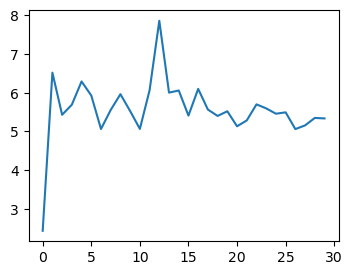

In [72]:
# ежедневный доход с пользователя
df_by_day = df[filt].groupby(['date']).agg({'id_user':'count', 'sum_payment':'sum'})
df_by_day['user_payment'] = df_by_day['sum_payment'].astype(int) / df_by_day['id_user'].astype(int)
df_by_day.reset_index(inplace=True)
plt.figure(figsize=(4, 3))
plt.plot(df_by_day.user_payment)
plt.show()

In [73]:
# посчитаем 3 сигма интервал и посмотрим какие значения выпали. итеративно удалили выбросы
intervals = [np.mean(df_by_day['user_payment']) - 3 * np.std(df_by_day['user_payment']), np.mean(df_by_day['user_payment']) + 3 * np.std(df_by_day['user_payment'])]
df_by_day = df_by_day[df_by_day.user_payment.apply(lambda x: True if intervals[0] < x and x < intervals[1] else False)]
intervals = [np.mean(df_by_day['user_payment']) - 3 * np.std(df_by_day['user_payment']), np.mean(df_by_day['user_payment']) + 3 * np.std(df_by_day['user_payment'])]
df_by_day = df_by_day[df_by_day.user_payment.apply(lambda x: True if intervals[0] < x and x < intervals[1] else False)]
intervals = [np.mean(df_by_day['user_payment']) - 3 * np.std(df_by_day['user_payment']), np.mean(df_by_day['user_payment']) + 3 * np.std(df_by_day['user_payment'])]
df_by_day = df_by_day[df_by_day.user_payment.apply(lambda x: True if intervals[0] < x and x < intervals[1] else False)]
out_dates = list(set(df[filt].date) - set(df_by_day.date))

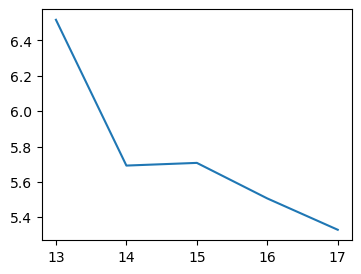

In [74]:
# еженедельный доход с пользователя
df_by_week = df[df.date.isin(list(df_by_day.date))].groupby(['week']).agg({'id_user':'count', 'sum_payment':'sum'})
df_by_week['user_payment'] = df_by_week['sum_payment'].astype(int) / df_by_week['id_user'].astype(int)
plt.figure(figsize=(4, 3))
plt.plot(df_by_week.user_payment)
plt.show()

In [75]:
# посчитаем 3 сигма интервал и посмотрим какие значения выпали
intervals = [np.mean(df_by_week['user_payment']) - 3 * np.std(df_by_week['user_payment']), np.mean(df_by_week['user_payment']) + 3 * np.std(df_by_week['user_payment'])]
df_by_week[df_by_week.user_payment.apply(lambda x: True if intervals[0] < x and x < intervals[1] else False)]

,id_user,sum_payment,user_payment
week,,,
13,60,391,6.516667
14,1261,7178,5.692308
15,2896,16529,5.707528
16,6318,34790,5.506489
17,14743,78570,5.329309


In [76]:
# чистим выбросы и считаем средний платеж пользователя за неделю после первого показа
df_payment_users_per_week = df[filt].query(f"is_pay==1 & date not in {out_dates}").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index()
s_pay = df_payment_users_per_week.sum_payment
intevals = [np.mean(s_pay) - np.std(s_pay) * 3, np.mean(s_pay) + np.std(s_pay) * 3]
df_payment_users_per_week = df_payment_users_per_week[df_payment_users_per_week.sum_payment.apply(lambda x: False if not intevals[0] < x < intevals[1] else True)]
s_pay = df_payment_users_per_week.sum_payment
intevals = [np.mean(s_pay) - np.std(s_pay) * 3, np.mean(s_pay) + np.std(s_pay) * 3]
df_payment_users_per_week = df_payment_users_per_week[df_payment_users_per_week.sum_payment.apply(lambda x: False if not intevals[0] < x < intevals[1] else True)]
df_payments_per_week = df_payment_users_per_week.groupby(['week']).agg({'sum_payment': 'mean'})
df_payments_per_week

,sum_payment
week,
13,21.722222
14,22.881967
15,22.854839
16,22.780181
17,24.601288


In [77]:
# средний платеж пользователя за неделю после первого показа
mean_per_week = np.mean(df_payment_users_per_week['sum_payment'])
mean_per_week

23.764717125382262

In [78]:
# 3 сигма по неделям
s_pay_week = df_payment_users_per_week.sum_payment
intervals = [np.mean(s_pay_week) - np.std(s_pay_week) * 3, np.mean(s_pay_week) + np.std(s_pay_week) * 3]
intervals

[-12.16471884936307, 59.69415310012759]

In [79]:
mean_users_per_week = np.mean(df_payment_users_per_week.groupby('week').agg({'id_user': 'count'})['id_user'])

### Оценка мощности

In [80]:
size = len(s_pay_week)
effect = mean_per_week * 0.1
n_exp = 5 
alpha = 0.05
scale = intervals[1] - mean_per_week

p_values = []
for i in range(n_exp):
    x_a = sps.norm.rvs(loc=10, scale=scale, size=size)
    x_b = sps.norm.rvs(loc=10 + effect, scale=scale, size=size)
    p_value = sps.ttest_ind(x_a, x_b).pvalue
    p_values.append(p_value)
p_values = np.array(p_values)
p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

100.0

In [81]:
# количество наблюдений для получения статзначимого эффекта
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1-alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1**2+sigma_2**2/k) / (delta_effect **2)
    return np.ceil(n)

In [82]:
dur = duration(k=1, delta_effect=mean_per_week * 0.1, sigma_1=intervals[0], sigma_2=intervals[1])
print("Продолжительность теста по количеству наблюдений:", int(dur))
print("Продолжительность теста по количеству недель:", int(np.ceil(dur / mean_users_per_week)))
days = int(np.ceil(dur / mean_users_per_week * 7)) 
print("Продолжительность теста по количеству дней:", days)

Продолжительность теста по количеству наблюдений: 10316
Продолжительность теста по количеству недель: 10
Продолжительность теста по количеству дней: 70


In [83]:
# сравнение дат окончания пилота
end_test = (datetime.strptime('2023-04-30', "%Y-%m-%d") + timedelta(days)).strftime('%Y-%m-%d')
print(f"Предложенная дата окончания пилота {df[filt].date.max().replace('4', '5')}")
print(f"Рассчитанная дата окончания пилота {end_test}")

Предложенная дата окончания пилота 2023-05-30
Рассчитанная дата окончания пилота 2023-07-09


In [84]:
filt_pilot = (df.date > '2023-05-01') & (df.date < end_test)
df_pilot_A = df[filt_pilot].query("group=='A'")
df_pilot_B = df[filt_pilot].query("group=='B'")

In [85]:
# функция удаления выбросов
def clean_data(df_):
    for _ in range(2):
        s_pay = df_.sum_payment
        intevals = [np.mean(s_pay) - np.std(s_pay) * 3, np.mean(s_pay) + np.std(s_pay) * 3]
        df_ = df_[df_.sum_payment.apply(lambda x: False if not intevals[0] < x < intevals[1] else True)]
    return df_
    

In [86]:
# чистим выбросы и считаем средний платеж пользователя за неделю после первого показа
df_payment_users_per_week_A = clean_data(df_pilot_A.query(f"is_pay==1").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index())
df_payment_users_per_week_A.head()

,week,id_user,sum_payment
0,18,user_10088,13
1,18,user_10140,12
2,18,user_10264,10
3,18,user_10276,37
4,18,user_10396,20


In [87]:
# чистим выбросы и считаем средний платеж пользователя за неделю после первого показа
df_payment_users_per_week_B = clean_data(df_pilot_B.query(f"is_pay==1").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index())
df_payment_users_per_week_B.head()

,week,id_user,sum_payment
0,18,user_10183,31
1,18,user_1033,13
2,18,user_10437,31
3,18,user_10481,28
4,18,user_10687,13


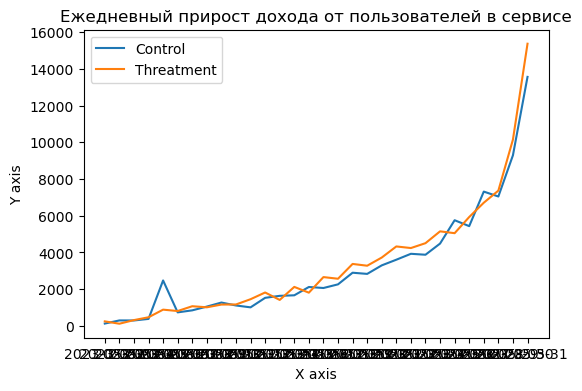

In [88]:
# по дням
df_per_day_A = df_pilot_A.query(f"is_pay==1").groupby(['date']).agg({'sum_payment': 'sum'}).reset_index().set_index('date')
df_per_day_B = df_pilot_B.query(f"is_pay==1").groupby(['date']).agg({'sum_payment': 'sum'}).reset_index().set_index('date')
df_per_day_clean_A = df_per_day_A
df_per_day_clean_B = df_per_day_B


s_pay = df_payment_users_per_week.sum_payment
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_per_day_clean_A.index, df_per_day_clean_A, label='Control')
ax.plot(df_per_day_clean_B.index, df_per_day_clean_B, label='Threatment')
ax.legend()
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Ежедневный прирост дохода от пользователей в сервисе')
plt.show()


In [89]:
# функция удаления выбросов
def clean_data_2(df_):
    i = 0
    step=10
    drop_set = set()
    while i+step < len(df_):
    
        for _ in range(2):
            s_pays = df_.sum_payment[i:i+step].to_dict()
            s_pay = list(s_pays.values())
            q1, q3 = np.percentile(s_pay, [25, 75])
            iqr = q3 - q1
            median = np.median(s_pay)


            # Определить границы выбросов с помощью метода Тьюки:
            intevals = [median - 1.5 * iqr, median + 1.5 * iqr]
            for k,v in s_pays.items():
                if intevals[0] < v < intevals[1]:
                    drop_set.add(k)
        i+=1
    return drop_set

In [90]:
# удаление выбросов по датам методом Тьюки
idxs = list(clean_data_2(df_per_day_A) & clean_data_2(df_per_day_B))
df_per_day_clean_A = df_per_day_A.loc[idxs].sort_values('date')
df_per_day_clean_B = df_per_day_B.loc[idxs].sort_values('date')

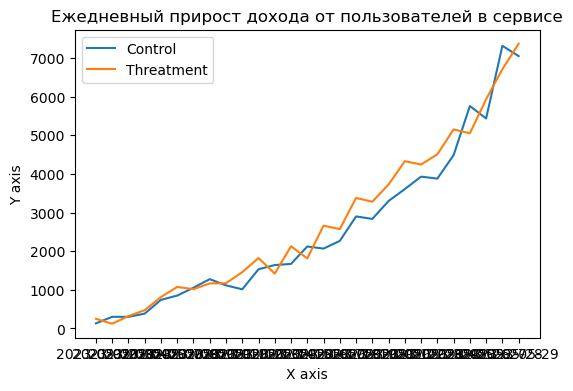

In [91]:
# отрисуем после удаления выбросов
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_per_day_clean_A.index, df_per_day_clean_A, label='Control')
ax.plot(df_per_day_clean_B.index, df_per_day_clean_B, label='Threatment')
ax.legend()
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Ежедневный прирост дохода от пользователей в сервисе')
plt.show()


In [92]:
# повторная чистка в неделях
df_payment_users_per_week_A = df_pilot_A.query(f"is_pay==1 & date in {idxs}").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index()
df_payment_users_per_week_B = df_pilot_B.query(f"is_pay==1 & date in {idxs}").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index()

### Посмотрим пересечения интервалов

In [93]:
alpha=0.05
c = sps.norm.ppf(1 - alpha/2)
x1 = df_payment_users_per_week_A.sum_payment
mean_1 = x1.mean()
std_1 = x1.std(ddof=1)

x2 = df_payment_users_per_week_B.sum_payment
mean_2 = x2.mean()
std_2 = x2.std(ddof=1)
    
CI_1 = [mean_1 - c*std_1 / np.sqrt(len(x1)), mean_1 + c*std_1 / np.sqrt(len(x1))]

CI_2 = [mean_2 - c*std_2 / np.sqrt(len(x2)), mean_2 + c*std_2 / np.sqrt(len(x2))]

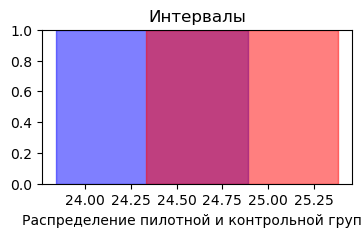

In [94]:
# отрисуем интервалы 2х выборок

# Интервалы
interval1 = CI_1
interval2 = CI_2

# Создаем график
fig, ax = plt.subplots(figsize=(4,2))
# Отрисовываем интервалы
ax.axvspan(interval1[0], interval1[1], alpha=0.5, color='blue')
ax.axvspan(interval2[0], interval2[1], alpha=0.5, color='red')
ax.set_xlabel('Распределение пилотной и контрольной групп')
ax.set_title('Интервалы')
plt.show()


### Рассчитаем значимость по критерию T-test

In [95]:
x_a = df_payment_users_per_week_A.sum_payment
x_b = df_payment_users_per_week_B.sum_payment
t_stat, p_value = sps.ttest_ind(x_a, x_b)

print("t-статистика: ", t_stat)
print("p-value: ", p_value)
print(f"{'отвергаем нулевую гипотезу' if p_value < alpha else 'результаты статистически незначимы'}")

t-статистика:  -1.2997840787713988
p-value:  0.1937266116070455
результаты статистически незначимы


### Рассчитаем значимость по критерию Манна-Уитни

In [96]:
mw_stat, p_value = sps.mannwhitneyu(x_a, x_b)

print("U-статистика: ", mw_stat)
print("p-value: ", p_value)
print(f"{'отвергаем нулевую гипотезу' if p_value < alpha else 'результаты статистически незначимы'}")

U-статистика:  4145002.0
p-value:  0.3090374237897523
результаты статистически незначимы


### Бутстрапируем выборки

In [145]:
def get_bootstrap_sample_indices(sample_size: int, n_samples: int) -> np.ndarray:
    return np.random.randint(0, sample_size, (n_samples, sample_size))

def get_bootstrap_samples(X: np.ndarray, n_samples: int) -> np.ndarray:
    return X[get_bootstrap_sample_indices(len(X), n_samples)]

In [155]:
x_a = np.array(df_payment_users_per_week_A.sum_payment)
X_bootstrap_A = get_bootstrap_samples(x_a, n_samples=1_000)
metrics_median_A = np.median(X_bootstrap_A, axis=1)
CI = np.percentile(metrics_median_A, (alpha * 100, (1 - alpha) * 100))
print(f"Percentile {CI}")
go.Figure([go.Histogram(x=metrics_median_A)])

Percentile [20. 20.]


In [156]:
x_b = np.array(df_payment_users_per_week_B.sum_payment)
X_bootstrap_B = get_bootstrap_samples(x_b, n_samples=1_000)
metrics_median_B = np.median(X_bootstrap_B, axis=1)
CI = np.percentile(metrics_median_B, (alpha * 100, (1 - alpha) * 100))
print(f"Percentile {CI}")
go.Figure([go.Histogram(x=metrics_median_B)])

Percentile [20. 22.]


In [157]:
x_a = metrics_median_A
x_b = metrics_median_B
p_value = sps.ttest_ind(x_a, x_b).pvalue

print("p-value: ", p_value)
print(f"{'отвергаем нулевую гипотезу' if p_value < alpha else 'результаты статистически незначимы'}")

p-value:  3.7930965788593704e-29
отвергаем нулевую гипотезу


### Давайте проделамем все тоже самое только отдельно по городам

#### Москва

In [100]:
alpha=0.05

In [162]:
# ежедневный доход с пользователя
for city in ['Санкт-Петербург', 'Ярославь', 'Москва', 'Тула', 'Рязань']:
    print(f"-------{city}-------")
    df_b_day = df.query(f"city=='{city}'")[filt].groupby(['date']).agg({'id_user':'count', 'sum_payment':'sum'})
    df_b_day['user_payment'] = df_b_day['sum_payment'].astype(int) / df_b_day['id_user'].astype(int)
    df_b_day.reset_index(inplace=True)
    # посчитаем 3 сигма интервал и посмотрим какие значения выпали. итеративно удалили выбросы
    intervals = [np.mean(df_b_day['user_payment']) - 3 * np.std(df_b_day['user_payment']), np.mean(df_b_day['user_payment']) + 3 * np.std(df_b_day['user_payment'])]
    df_b_day = df_b_day[df_b_day.user_payment.apply(lambda x: True if intervals[0] < x and x < intervals[1] else False)]
    out_dates = list(set(df[filt].date) - set(df_b_day.date))
    df_payment_users_per_week = df[filt].query(f"is_pay==1 & date not in {out_dates}").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index()
    s_pay = df_payment_users_per_week.sum_payment
    intevals = [np.mean(s_pay) - np.std(s_pay) * 3, np.mean(s_pay) + np.std(s_pay) * 3]
    df_payment_users_per_week = df_payment_users_per_week[df_payment_users_per_week.sum_payment.apply(lambda x: False if not intevals[0] < x < intevals[1] else True)]
    mean_per_week = np.mean(df_payment_users_per_week['sum_payment'])
    mean_users_per_week = np.mean(df_payment_users_per_week.groupby('week').agg({'id_user': 'count'})['id_user'])
    mean_users_per_day = np.mean(df_b_day.groupby('date').agg({'id_user': 'count'})['id_user'])
    dur = duration(k=1, delta_effect=mean_per_week * 0.1, sigma_1=intervals[0], sigma_2=intervals[1])
    days = int(np.ceil(dur / mean_users_per_day)) 

    end_test = (datetime.strptime('2023-04-30', "%Y-%m-%d") + timedelta(days)).strftime('%Y-%m-%d')
    filt_pilot = (df.date >= '2023-05-01') & (df.date <= end_test)
    
    df_pil_A = df[filt_pilot].query(f"group=='A' & city=='{city}' ")
    df_pil_B = df[filt_pilot].query(f"group=='B' & city=='{city}'")
    df_p_day_A = df_pil_A.groupby(['date']).agg({'sum_payment': 'sum'})#.reset_index().set_index('date')
    df_p_day_B = df_pil_B.groupby(['date']).agg({'sum_payment': 'sum'})#.reset_index().set_index('date')

    idxs = list(clean_data_2(df_p_day_A) & clean_data_2(df_p_day_B))
    df_payment_users_p_week_A = df_pil_A.query(f"is_pay==1 & city=='{city}'").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index()
    df_payment_users_p_week_B = df_pil_B.query(f"is_pay==1 & city=='{city}'").groupby(['week', 'id_user']).agg({'sum_payment': 'sum'}).reset_index()
    x_a = df_payment_users_p_week_A.sum_payment
    x_b = df_payment_users_p_week_B.sum_payment
    t_stat, p_value = sps.ttest_ind(x_a, x_b)
    print("============================")
    print("t-статистика: ", t_stat)
    print("p-value: ", p_value)
    print(f"{'отвергаем нулевую гипотезу' if p_value < alpha else 'результаты статистически незначимы'}")
    print("============================")
    

-------Санкт-Петербург-------


/tmp/ipykernel_32/2349191029.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



t-статистика:  0.05653264976477329
p-value:  0.9549251017650928
результаты статистически незначимы
-------Ярославь-------
t-статистика:  -0.4756423015502553
p-value:  0.6344001946126269
результаты статистически незначимы
-------Москва-------


/tmp/ipykernel_32/2349191029.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_32/2349191029.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



t-статистика:  1.13681157803652
p-value:  0.25579289232338553
результаты статистически незначимы
-------Тула-------
t-статистика:  -1.5865478961078827
p-value:  0.11302402904225448
результаты статистически незначимы
-------Рязань-------


/tmp/ipykernel_32/2349191029.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_32/2349191029.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



t-статистика:  -1.2028386870020635
p-value:  0.22916117183189902
результаты статистически незначимы
